# Solución de problemas con pipelines - Preprocesamiento

En este tutorial aprenderás cómo crear pipelines para realizar todo el preprocesamiento de datos, realizando la búsqueda de hiperparámetros y entrenando un modelo de árboles de decisión. Adicionalmente, evaluarás el mejor modelo usando métricas de rendimiento para un problema de clasificación. Específicamente, verás cómo realizar los siguientes procesos:

1. Importar las librerías requeridas.
2. Cargar un conjunto de datos.
3. Explorar el conjunto de datos.
4. Definir los pasos y ejecutar el preprocesamiento de datos mediante un pipeline.
5. Realizar la búsqueda de hiperparámetros para el modelo de árbol de decisión.
6. Evaluar el mejor modelo resultante.

Utilizaremos el conjunto de datos correspondiente a la compra de seguros de viaje. En este problema queremos predecir si una persona va a comprar un seguro de viaje dependiendo de factores como su edad, salario, educación, entre otros.

## 1. Importación de librerías requeridas

Importaremos las librerías `pandas`, `matplotlib`, `numpy` y `scikit-learn`. En particular, usaremos las siguientes clases y funciones para construir el pipeline, así como entrenar y evaluar el modelo de árboles de decisión:

* `Pipeline()`: clase para construir el pipeline.
* `SimpleImputer()`: clase para realizar la imputación de datos.
* `ColumnTransformer()`: clase para realizar transformaciones por columnas.
* `StandardScaler()`: clase para realizar la estandarización.
* `OneHotEncoder()`: clase para realizar la codificación OneHot.
* `DecisionTreeClassifier()`: clase para crear el modelo de árbol de decisión.
* `classification_report()`: función para obtener un reporte con las métricas de rendimiento por clase.
* `plot_confusion_matrix()`: función para graficar la matriz de confusión.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix

## 2. Carga de datos

Realizaremos la carga de datos usando la función de Pandas `read_csv()`, especificando la ruta y el separador del archivo:

In [2]:
data_raw = pd.read_csv('data/TravelInsurancePrediction.csv', sep=',')

Veamos los primeros datos del conjunto utilizando `head()`:

In [3]:
data_raw.head()

,Index,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31.0,Government Sector,Yes,400000.0,6.0,1.0,No,No,0
1,1,31.0,Private Sector/Self Employed,Yes,1250000.0,7.0,0.0,No,No,0
2,2,34.0,Private Sector/Self Employed,Yes,500000.0,4.0,1.0,No,No,1
3,3,28.0,Private Sector/Self Employed,Yes,700000.0,3.0,1.0,No,No,0
4,4,28.0,Private Sector/Self Employed,Yes,700000.0,8.0,1.0,Yes,No,0


Como puedes observar, nuestro conjunto de datos contiene cinco variables categóricas: `Employment Type`, `GraduateOrNot`, `ChronicDiseases`, `FrequentFlyer` y `EverTravelledAbroad`.

## 3. Exploración del conjunto de datos

Primero utilizaremos `data_raw.describe()` para obtener una descripción de las variables numéricas del conjunto de datos. Ten en cuenta que esta función también incluye variables categóricas con clases numéricas como, por ejemplo, la variable `ChronicDiseases` o la variable objetivo `TravelInsurance`:

In [4]:
data_raw.describe()

,Index,Age,AnnualIncome,FamilyMembers,ChronicDiseases,TravelInsurance
count,1987.000000,1939.000000,1.937000e+03,1931.000000,1940.000000,1987.000000
mean,993.000000,29.670449,9.358286e+05,4.767996,0.278866,0.357323
std,573.741812,2.910996,3.762435e+05,1.614709,0.448557,0.479332
min,0.000000,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,496.500000,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,993.000000,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,1489.500000,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,1986.000000,35.000000,1.800000e+06,9.000000,1.000000,1.000000


Podemos utilizar `value_counts` para obtener cada valor posible de las variables categóricas y su frecuencia de aparición sobre el total de los datos. Por ejemplo, obtendremos la distribución de valores para la variable `Employment Type`:

In [5]:
pd.value_counts(data_raw['Employment Type'])

Private Sector/Self Employed    1356
Government Sector                547
Name: Employment Type, dtype: int64

## 4. Definición de pasos y ejecución del preprocesamiento de datos

Primero vamos a definir la variable `data` para almacenar un conjunto de datos modificado, utilizando el método `copy()`:

In [6]:
data = data_raw.copy()

### Eliminación de variables poco relevantes

Este conjunto de datos solo tiene una variable poco relevante para predecir si el cliente va a comprar un seguro de viajes: `Index`. Haciendo uso de la función `drop()`, eliminaremos esta variable del DataFrame:

In [7]:
data = data.drop('Index', axis=1)

### Tratamiento de nulos y duplicados

Veremos si hay duplicados utilizando `duplicated().sum()`:

In [8]:
data.duplicated().sum()

486

Podemos tratar directamente los datos duplicados antes de entrar al pipeline mediante la función `drop_duplicates()` de Pandas: 

In [9]:
data = data.drop_duplicates()

Adicionalmente, revisaremos si nuestros datos contienen datos nulos usando `isna().sum()`:

In [10]:
data.isna().sum()

Age                    48
Employment Type        83
GraduateOrNot          65
AnnualIncome           48
FamilyMembers          51
ChronicDiseases        47
FrequentFlyer          90
EverTravelledAbroad    92
TravelInsurance         0
dtype: int64

En vez de eliminar estos datos, definiremos una etapa dentro del pipeline que los tratará para poder utilizarlos dentro del entrenamiento. Específicamente, realizaremos una imputación de datos para reemplazar los valores nulos por valores como la media, mediana, entre otros. En ese sentido, definiremos un objeto de la clase `SimpleImputer()`, especificando que reemplazaremos los valores nulos por el valor más frecuente. Ten en cuenta que utilizamos esta estrategia para poder tratar variables tanto numéricas como categóricas: 

In [11]:
simple_imputer = SimpleImputer(strategy='most_frequent')

### Transformación de variables categóricas

Teóricamente, el modelo de árboles de decisión no necesita que todas las variables sean numéricas, pues simplemente genera divisiones según un criterio a optimizar, usando la distribución de los valores para cada variable. Sin embargo, la implementación de `sklearn` necesita que todos los valores de las variables sean numéricos, por lo que realizaremos una codificación OneHot. En este caso, incluiremos la codificación dentro del pipeline mediante un objeto de la clase `OneHotEncoder()`:

In [12]:
encoder = OneHotEncoder()

### Estandarización de variables numéricas

Igualmente, el modelo de árboles de decisión no necesita estandarizar las variables para realizar las particiones. Sin embargo, incluiremos un paso de estandarización por completitud de nuestro pipeline de preprocesamiento, haciendo uso de un objeto de la clase `StandardScaler()`: 

In [13]:
scaler = StandardScaler()

En este punto debes notar que no hemos especificado las columnas que serán procesadas por el paso de codificación y por el paso de estandarización, por lo que podemos afectar variables que no corresponden. Para especificar qué variables deben ser modificadas por cada uno de los objetos utilizaremos un objeto de la clase `ColumnTransformer()`, que recibe una lista de tuplas `(nombre, objeto, columnas)` especificando qué objeto se usará con qué conjunto de variables:

In [15]:
# Variables Age, AnnualIncome, FamilyMembers
numeric_features = [0, 3, 4]
# Variables Employment Type, GraduateOrNot, ChronicDiseases, FrequentFlyer, EverTravelledAbroad
categorical_features = [1, 2, 5, 6, 7]

column_transformer = ColumnTransformer(
    transformers=[
        ("num", scaler, numeric_features),
        ("cat", encoder, categorical_features)
    ]
)

Como puedes ver, especificamos dos listas con los índices de las variables numéricas y categóricas (`numeric_features` y `categorical_features`) que utilizaremos para especificar el parámetro `transformers`. En total, el objeto `column_transformer` es el que incluiremos en nuestro pipeline.

### Creación del pipeline

La librería `scikit-learn` utiliza el concepto de transformadores y estimadores para la implementación de todas sus clases. Un transformador es un objeto que implementa los métodos `fit()` y `transform()`, que procesan un conjunto de datos de entrada y aplican operaciones sobre ellos. Por otro lado, un estimador es un objeto que implementa el método `fit()` y genera modelos a partir de datos. En ese sentido, un pipeline es una estructura que aplica transformadores secuecialmente y termina con un estimador sobre un conjunto de datos. 

Para nuestro problema definiremos la secuencia de pasos que aplicaremos sobre el conjunto de datos, utilizando tuplas de la forma `(nombre, objeto)`:

In [16]:
steps = [
    ("imputer",simple_imputer),
    ("transformer",column_transformer),
]

Con la secuencia de pasos definida, crearemos un objeto de la clase `Pipeline()` para realizar el preprocesamiento:

In [17]:
pipeline = Pipeline(steps)

### División de datos

Ahora dividiremos el conjunto de datos resultante en un conjunto de entrenamiento y uno de pruebas mediante la función `train_test_split()`. Usaremos el 80% de los datos para el entrenamiento y el 20% restante para las pruebas:

In [18]:
train, test = train_test_split(data, test_size=0.2, random_state=9)
train.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
857,28.0,Government Sector,Yes,600000.0,3.0,0.0,No,No,1
783,29.0,Private Sector/Self Employed,Yes,1100000.0,7.0,0.0,NaN,No,0
1326,34.0,Private Sector/Self Employed,Yes,700000.0,5.0,0.0,No,No,0
1780,31.0,Private Sector/Self Employed,Yes,950000.0,NaN,0.0,Yes,No,0
1424,31.0,Government Sector,Yes,400000.0,9.0,0.0,No,No,0


Además, separaremos la variable objetivo `TravelInsurance` de las variables descriptoras:

In [19]:
x_train = train.drop(['TravelInsurance'],axis=1)
y_train = train['TravelInsurance']

Posteriormente, vamos a utilizar el pipeline de preprocesamiento para transformar el conjunto de datos mediante la función `fit_transform()`. Debes tener en cuenta que el conjunto de datos resultante es un arreglo de `numpy`, por lo que si quieres reconstruir el DataFrame, es necesario utilizar el diccionario de datos:

In [20]:
x_train_transformed = pipeline.fit_transform(x_train)
x_train_transformed

array([[-0.55831904, -0.91043782, -1.10867577, ...,  0.        ,
         1.        ,  0.        ],
       [-0.21117767,  0.47478519,  1.26176686, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.5245292 , -0.63339322,  0.07654554, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.90546042, -0.21782632, -1.70128643, ...,  0.        ,
         0.        ,  1.        ],
       [-0.90546042,  1.72148589,  0.6691562 , ...,  1.        ,
         1.        ,  0.        ],
       [ 0.48310508,  1.30591899, -1.10867577, ...,  1.        ,
         0.        ,  1.        ]])

## 5. Búsqueda de hiperparámetros para el modelo de árbol de decisión

Con el conjunto de datos modificado, crearemos un objeto de la clase `DecisionTreeClassifier()` que será nuestro modelo base para realizar la búsqueda exhaustiva de hiperparámetros:

In [22]:
decision_tree = DecisionTreeClassifier(random_state=0)

Utilizaremos los siguientes parámetros para realizar la búsqueda:
* `criterion`: el criterio de pureza, que determina la calidad de una división. Utilizaremos dos de los más populares: la entropía y GINI.
* `max_depth`: la profundidad máxima del árbol. Este hiperparámetro se utiliza para el control de la complejidad del modelo.
* `min_samples_split`: número mínimo de datos necesarios en un nodo para poder definir una división.

In [23]:
param_grid = {'criterion': ['entropy', 'gini'],
              'max_depth': [2, 4, 6, 8],
              'min_samples_split': [2, 3, 5, 10]}

Además, definiremos un objeto de la clase `KFold()` para realizar la validación cruzada con 10 subconjuntos de datos:

In [24]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

Finalmente, definiremos la búsqueda con un objeto de la clase `GridSearchCV()` usando el modelo `decision_tree`, el espacio de búsqueda `param_grid` y la técnica de validación cruzada `kfold`:

In [25]:
grid = GridSearchCV(decision_tree, param_grid, cv=kfold, n_jobs=-1)

Ejecutaremos la búsqueda sobre el conjunto de entrenamiento modificado con el pipeline, definido por las variables `x_train_transformed` y `y_train`:

In [26]:
grid.fit(x_train_transformed, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
          

Ahora obtendremos los mejores valores de los hiperparámetros usando `grid.best_params_`:

In [27]:
print("Mejores parámetros: {}".format(grid.best_params_))

Mejores parámetros: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}


Como puedes ver, el mejor modelo utiliza la entropía como criterio de pureza, una profundidad máxima de 4 y un mínimo de 2 datos para realizar una división. Almacenaremos el mejor modelo utilizando `grid.best_estimator_`:

In [28]:
mejor_modelo = grid.best_estimator_

## 6. Evaluación del mejor modelo

Empezaremos separando la variable objetivo de las variables descriptoras en el conjunto de pruebas:

In [29]:
x_test = test.drop(['TravelInsurance'],axis=1)
y_test = test['TravelInsurance']

Con la información disponible del conjunto de entrenamiento, haremos uso de la función `transform()` del pipeline para transformar el conjunto de pruebas, obteniendo un arreglo de `numpy`:

In [30]:
x_test_transformed = pipeline.transform(x_test)
x_test_transformed

array([[-0.90546042, -0.35634862,  0.07654554, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.87167058,  0.47478519,  1.85437752, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.48310508,  0.75182979, -1.10867577, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.48310508,  0.89035209,  0.07654554, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.13596371, -1.04896012,  1.26176686, ...,  1.        ,
         1.        ,  0.        ],
       [-1.59974317,  1.16739669,  0.6691562 , ...,  0.        ,
         0.        ,  1.        ]])

A continuación realizaremos predicciones sobre el conjunto de pruebas transformado para comparar con los valores de `y_test`. Utilizaremos la función `predict()` sobre el mejor modelo:

In [31]:
y_pred = mejor_modelo.predict(x_test_transformed)

Ahora utilizaremos la función `plot_confusion_matrix()` para generar un mapa de calor con los valores de la matriz de confusión:

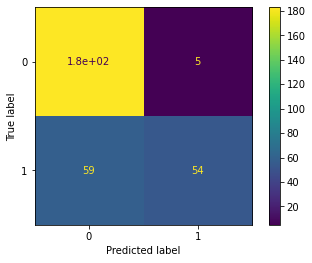

In [32]:
plot_confusion_matrix(mejor_modelo, x_test_transformed, y_test)  
plt.show()

Como puedes observar, el modelo tiende a predecir correctamente la clase 0, es decir, tiene mejor desempeño al predecir a las personas que no van a comprar un seguro de viaje. De hecho, para la clase 1, el modelo tiende a predecir erróneamente. Específicamente, podemos observar las métricas de desempeño usando `classification_report()`:

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.97      0.85       188
           1       0.92      0.48      0.63       113

    accuracy                           0.79       301
   macro avg       0.84      0.73      0.74       301
weighted avg       0.82      0.79      0.77       301



En este modelo se tienen valores altos en la sensibilidad de la clase 0. Como la clase 1 no tiene tanta representación, se tiene una sensibilidad bastante baja, aunque la precisión tiene un valor alto. Este valor de precisión indica que de los datos que el árbol clasifica en la clase 1 la mayoría realmente pertenecen a esta clase.